<div style="text-align: center;">
    <span style="font-family: Georgia; font-size: 32px;">
         Forecasting Yield of Crop Products using MLP

<div style="text-align: center;">
    <span style="font-family: Georgia; font-size: 24px;">
Candidate number  : 291717 
    </span>
</div>
        
<div style="text-align: right;">
    <span style="font-family: Georgia; font-size: 11px;color: red;">
    Date: 1, June, 2025
</div>

# 1: Required Python Libraries and Reading Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import RFE, SequentialFeatureSelector
from sklearn.utils.class_weight import compute_sample_weight
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm #  to visually track the progress of long-running operations, and helps me remain patient
from scipy.stats import pearsonr, PermutationMethod
import random
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')


#### Versions of all the packages used in this report
print(f"seaborn: {sns.__version__}")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"scikit-learn: {sklearn.__version__}")
print(f"torch: {torch.__version__}")

seaborn: 0.13.2
pandas: 2.2.2
numpy: 1.26.4
matplotlib: 3.9.2
scikit-learn: 1.5.1
torch: 2.7.0+cpu


In [2]:
# I want to see all the columns in merged datasets (not truncated)
pd.set_option('display.max_columns', None) 

Defining a __Function__ for reading the data set 

In [3]:
def read_data(name_dir):
    """This function reads all CSV files in a given folder and returns dataframes
    - "name_dir" is a string containing the location of the directory of the dataset (e.g., "ML/data/"),
    - Function is returning the dataframes associated to the assignment. 
    - You just need to change "name_dir" to match where the data is saved on your computer"""
    DataFrames = {}
    for csv_file in os.listdir(name_dir):
        if csv_file.endswith('.csv'): 
            csv_path  = os.path.join(name_dir, csv_file)
            df = pd.read_csv(csv_path)
            df_name = os.path.splitext(csv_file)[0]
            DataFrames[df_name] = df
    c=1
    for name, df in DataFrames.items():
        print(f"{c}: {name} ...... \u2713")
        c=c+1
    return DataFrames

In [4]:
''' file location '''
DataFrames = read_data(r"C:\Users\F\Downloads\OneDrive_1_01-05-2025")   #   read_data (r"file path goes here")

1: CanopInt_inst_data ...... ✓
2: country_latitude_longitude_area_lookup ...... ✓
3: ESoil_tavg_data ...... ✓
4: Land_cover_percent_data ...... ✓
5: Rainf_tavg_data ...... ✓
6: Snowf_tavg_data ...... ✓
7: SoilMoi0_10cm_inst_data ...... ✓
8: SoilMoi100_200cm_inst_data ...... ✓
9: SoilMoi10_40cm_inst_data ...... ✓
10: SoilMoi40_100cm_inst_data ...... ✓
11: SoilTMP0_10cm_inst_data ...... ✓
12: SoilTMP100_200cm_inst_data ...... ✓
13: SoilTMP10_40cm_inst_data ...... ✓
14: SoilTMP40_100cm_inst_data ...... ✓
15: TVeg_tavg_data ...... ✓
16: TWS_inst_data ...... ✓
17: Yield_and_Production_data ...... ✓


In [5]:
#Separating tables from loaded dictionary of csv files (output of read_data() function is a dictionary of DataFrames )
CanopInt_inst_data = DataFrames['CanopInt_inst_data']
country_latitude_longitude_area_lookup = DataFrames['country_latitude_longitude_area_lookup']
ESoil_tavg_data = DataFrames['ESoil_tavg_data']
Land_cover_percent_data = DataFrames['Land_cover_percent_data']
Rainf_tavg_data = DataFrames['Rainf_tavg_data']
Snowf_tavg_data = DataFrames['Snowf_tavg_data']
SoilMoi0_10cm_inst_data = DataFrames['SoilMoi0_10cm_inst_data']
SoilMoi10_40cm_inst_data = DataFrames['SoilMoi10_40cm_inst_data']
SoilMoi40_100cm_inst_data = DataFrames['SoilMoi40_100cm_inst_data']
SoilMoi100_200cm_inst_data = DataFrames['SoilMoi100_200cm_inst_data']
SoilTMP0_10cm_inst_data = DataFrames['SoilTMP0_10cm_inst_data']
SoilTMP10_40cm_inst_data = DataFrames['SoilTMP10_40cm_inst_data']
SoilTMP40_100cm_inst_data = DataFrames['SoilTMP40_100cm_inst_data']
SoilTMP100_200cm_inst_data = DataFrames['SoilTMP100_200cm_inst_data']
TVeg_tavg_data = DataFrames['TVeg_tavg_data']
TWS_inst_data = DataFrames['TWS_inst_data']
Yield_and_Production_data = DataFrames['Yield_and_Production_data']

# 2: Summary statistics

In [6]:
## Summary Statistics
## I already checked and deactivated this box as it creats a lengthy report
#for name, df in DataFrames.items():
#    print(f"\n--- .describe() Statistics for {name} ---")
#    print(df.describe(include='all'))  # includes all types (numerical + categorical)

#    print(f"\n--- .info() Statistics for {name} ---")
#    print(df.info())  # includes all types (numerical + categorical)

## 2-1 : Notes on summary statistics and Null values based

Null values and considerations: 
- __country_latitude_longitude_area_lookup:__ area column can  be removed, also there are instances in centroid radius that are zero(which means zero area- these are: Bouvet Island, British Indian Ocean Territory, French Southern Territories, Gaza Stri,p Mayotte, U.S. Minor Outlying Islands, Vatican City)
- __Land_cover_percent_data:__ among 17 land cover classes only clsas_12 (i.e., Croplands) and to some extent class 14 can be used in our analysis [based on refrence on readme file : 'In areas of the tropics where cropland eld sizes tend to be much smaller than a MODIS pixel, agriculture is sometimes underrepresented (i.e., labeled as natural vegetation).', class 14 def: 'Mosaics of small-scale cultivation 40-60% with natural tree, shrub, or herbaceous vegetation.'](https://modis-land.gsfc.nasa.gov/pdf/MCD12Q1_C6_Userguide04042018.pdf)
  
- __country_latitude_longitude_area_lookup:__ there is null value in centroid latitude & longitude columns  
- __TWS_inst_data:__ TWS_inst_month_2 , TWS_inst_month_3 has null values 
- __Yield_and_Production_data :__ columns/rows to be deleted are {Domain, Element/production, Item Code (CPC), Flag}
- The yield values are per year, so features related to soil moisture, soil temprature, rainfall, snowfall,  TVeg_tavg , TWS_inst, ESoil_tavg  should aggregated to year (from month)

In [7]:
# delete dataframe to save memory
del DataFrames

# 3: Data cleaning and wrangling

#### 3-1: Checking for duplicates, Null values and removing countries that have 'centroid radius' = 0

In [8]:
# removing countries with centroid radius equal to zero, because later we use centroid radius to find and match other tables
# longitude/latitude data to a country, and when centroid radius is zero, these cause problems as we look for minumum within radius distances to 
# assign coordinates to countries
zero_centroid_radius = country_latitude_longitude_area_lookup[country_latitude_longitude_area_lookup['centroid radius'] == 0]
print('1- Count of rows/countries with "centroid radius"=0 is ' , len(zero_centroid_radius), ' ,we remove these countries from dataset\n')
country_latitude_longitude_area_lookup = country_latitude_longitude_area_lookup[country_latitude_longitude_area_lookup['centroid radius'] != 0]

# and checking for duplicates and missing values in country_latitude_longitude_area_lookup table
duplicate_countries = country_latitude_longitude_area_lookup[country_latitude_longitude_area_lookup.duplicated('country')]
print("2- Duplicate countries:\n", duplicate_countries)

# checking for missing values in latitude and longitude
missing_values = country_latitude_longitude_area_lookup[country_latitude_longitude_area_lookup[['centroid latitude', 'centroid longitude']].isnull().any(axis=1)]
print("3- Rows with missing latitude or longitude:\n", missing_values)
country_latitude_longitude_area_lookup = country_latitude_longitude_area_lookup.dropna(subset=['centroid latitude', 'centroid longitude'])

# Checking for duplicate (lat., lon.) pairs
duplicate_coords = country_latitude_longitude_area_lookup[country_latitude_longitude_area_lookup.duplicated(['centroid latitude', 'centroid longitude'])]
print("4- Duplicate coordinate pairs:\n", duplicate_coords)

# area column can  be removed, no reason to keep it
country_latitude_longitude_area_lookup.drop(columns='area', inplace=True)

1- Count of rows/countries with "centroid radius"=0 is  7  ,we remove these countries from dataset

2- Duplicate countries:
 Empty DataFrame
Columns: [centroid latitude, centroid longitude, country, area, centroid radius]
Index: []
3- Rows with missing latitude or longitude:
 Empty DataFrame
Columns: [centroid latitude, centroid longitude, country, area, centroid radius]
Index: []
4- Duplicate coordinate pairs:
 Empty DataFrame
Columns: [centroid latitude, centroid longitude, country, area, centroid radius]
Index: []


#### 3-2: Only land-cover class-12 and class-14 are relevant to our analysis

In [9]:
Land_cover_percent_data['land_cover_percent_class_12_14'] = Land_cover_percent_data['Land_cover_percent_class_12'] + Land_cover_percent_data['Land_cover_percent_class_14']

# Keep only the required columns in Land_cover_percent_data set
Land_cover_percent_data = Land_cover_percent_data[['longitude', 'latitude', 'year', 'land_cover_percent_class_12_14']]

zero_land_rows = Land_cover_percent_data[Land_cover_percent_data['land_cover_percent_class_12_14'] == 0]
print('Count of rows with 0.00000% in "land_cover_percent_class_12_14" (croplands) column is:', len(zero_land_rows))

Count of rows with 0.00000% in "land_cover_percent_class_12_14" (croplands) column is: 627016


we keep these zero-land rows, because when later we join other tables with this, it gives us zero in place of NaN

#### 3-3: Removing Production data and unrelated columns in Yield_and_Production_data set

based on FAO website description on [Flags](https://www.fao.org/faostat/en/#definitions):  
A: Official figure  
E: Estimated value  
I: Imputed value  
M: Missing value (data cannot exist, not applicable)  
X: Figure from international organizations  
The Flag M is not acceptable for our analysis. (althought flags 'I' and 'E' are estimated and imputed, but I decided to use them in my modeling). Therefore I filter the data to not consider 'M' flags as they are reliable. 

In [10]:
Yield_and_Production_data = Yield_and_Production_data[Yield_and_Production_data['Flag']!= 'M' ]

In [11]:
##removing 'Domain', 'Flag' and 'Item Code (CPC)' from Yield_and_Production_data
Yield_and_Production_data.drop(columns=['Domain', 'Flag', 'Item Code (CPC)'], inplace = True)

In [12]:
# pivoting 'Element' column to separate production from yield
Yield_and_Production_data = Yield_and_Production_data.pivot(index=['Country', 'Item', 'Year'], columns='Element', values='Value').reset_index()

As we know the formula to compute yield is  __Yield= Production/AreaHarvested__, so the variable Production is already included in Yield, so I decided to remove production column from the dataset. (Including both Production and Yield as features can lead to data leakage. Production is not a true input feature but a result of the same outcome we're trying to predict)

In [13]:
# remove production column
Yield_and_Production_data.drop(columns=['Production'], inplace=True)

#### 3-4: Averaging monthly columns in climate and soil datasets per year

Based on the given units for SoilTMP [Kelvin], SoilMoi [$Kg/m^2$], Rainf_tavg [$Kg/m^2S$], TVeg_tavg[$Watts/m^2$], ESoil_tavg[$Watts/m^2$], CanopInt_inst [$Kg/m^2$], and TWS_inst [$mm$], and also considering their meaning, these variables reflects ongoing conditions that impact crops regularly, so in this report average behavior of monthly values over the year were considered.

In [14]:
#creating a list of names for monthly variables
monthly_cols_CanopInt = [f'CanopInt_inst_month_{i}' for i in range(1, 13)]
monthly_cols_Rainf = [f'Rainf_tavg_month_{i}' for i in range(1, 13)]
monthly_cols_Snowf = [f'Snowf_tavg_month_{i}' for i in range(1, 13)]
monthly_cols_ESoil = [f'ESoil_tavg_month_{i}' for i in range(1, 13)]
monthly_cols_SoilMoi0 = [f'SoilMoi0_10cm_inst_month_{i}' for i in range(1, 13)]
monthly_cols_SoilMoi10 = [f'SoilMoi10_40cm_inst_month_{i}' for i in range(1, 13)]
monthly_cols_SoilMoi40 = [f'SoilMoi40_100cm_inst_month_{i}' for i in range(1, 13)]
monthly_cols_SoilMoi100 = [f'SoilMoi100_200cm_inst_month_{i}' for i in range(1, 13)]
monthly_cols_SoilTMP0 = [f'SoilTMP0_10cm_inst_month_{i}' for i in range(1, 13)]
monthly_cols_SoilTMP10 = [f'SoilTMP10_40cm_inst_month_{i}' for i in range(1, 13)]
monthly_cols_SoilTMP40 = [f'SoilTMP40_100cm_inst_month_{i}' for i in range(1, 13)]
monthly_cols_SoilTMP100 = [f'SoilTMP100_200cm_inst_month_{i}' for i in range(1, 13)]
monthly_cols_TVeg = [f'TVeg_tavg_month_{i}' for i in range(1, 13)]
monthly_cols_TWS = [f'TWS_inst_month_{i}' for i in range(1, 13)]

# Compute monthly average over year (across rows)
CanopInt_inst_data['CanopInt_mean'] = CanopInt_inst_data[monthly_cols_CanopInt].mean(axis=1)
Rainf_tavg_data['Rainf_mean'] = Rainf_tavg_data[monthly_cols_Rainf].mean(axis=1)
Snowf_tavg_data ['Snowf_mean'] = Snowf_tavg_data[monthly_cols_Snowf].mean(axis=1)
ESoil_tavg_data['ESoil_mean'] = ESoil_tavg_data[monthly_cols_ESoil].mean(axis=1)
SoilMoi0_10cm_inst_data ['SoilMoi0_10_mean'] = SoilMoi0_10cm_inst_data[monthly_cols_SoilMoi0].mean(axis=1)
SoilMoi10_40cm_inst_data ['SoilMoi10_40_mean'] = SoilMoi10_40cm_inst_data[monthly_cols_SoilMoi10].mean(axis=1)
SoilMoi40_100cm_inst_data ['SoilMoi40_100_mean'] = SoilMoi40_100cm_inst_data[monthly_cols_SoilMoi40].mean(axis=1)
SoilMoi100_200cm_inst_data ['SoilMoi100_200_mean'] = SoilMoi100_200cm_inst_data[monthly_cols_SoilMoi100].mean(axis=1)
SoilTMP0_10cm_inst_data ['SoilTMP0_10_mean'] = SoilTMP0_10cm_inst_data[monthly_cols_SoilTMP0].mean(axis=1)
SoilTMP10_40cm_inst_data['SoilTMP10_40_mean'] = SoilTMP10_40cm_inst_data[monthly_cols_SoilTMP10].mean(axis=1)
SoilTMP40_100cm_inst_data['SoilTMP40_100_mean'] = SoilTMP40_100cm_inst_data[monthly_cols_SoilTMP40].mean(axis=1)
SoilTMP100_200cm_inst_data['SoilTMP100_200_mean'] = SoilTMP100_200cm_inst_data[monthly_cols_SoilTMP100].mean(axis=1)
TVeg_tavg_data ['TVeg_mean'] = TVeg_tavg_data[monthly_cols_TVeg].mean(axis=1)
TWS_inst_data['TWS_mean'] = TWS_inst_data[monthly_cols_TWS].mean(axis=1)

# Drop monthly columns (as we do not need them any more)
CanopInt_inst_data.drop(columns=monthly_cols_CanopInt, inplace=True)
Rainf_tavg_data.drop(columns=monthly_cols_Rainf, inplace=True)
Snowf_tavg_data.drop(columns=monthly_cols_Snowf, inplace=True)
ESoil_tavg_data.drop(columns=monthly_cols_ESoil, inplace=True)
SoilMoi0_10cm_inst_data.drop(columns=monthly_cols_SoilMoi0, inplace=True)
SoilMoi10_40cm_inst_data.drop(columns=monthly_cols_SoilMoi10, inplace=True)
SoilMoi40_100cm_inst_data.drop(columns=monthly_cols_SoilMoi40, inplace=True)
SoilMoi100_200cm_inst_data.drop(columns=monthly_cols_SoilMoi100, inplace=True) 
SoilTMP0_10cm_inst_data.drop(columns=monthly_cols_SoilTMP0, inplace=True) 
SoilTMP10_40cm_inst_data.drop(columns=monthly_cols_SoilTMP10, inplace=True)
SoilTMP40_100cm_inst_data.drop(columns=monthly_cols_SoilTMP40, inplace=True)
SoilTMP100_200cm_inst_data.drop(columns=monthly_cols_SoilTMP100, inplace=True)
TVeg_tavg_data.drop(columns=monthly_cols_TVeg, inplace=True) 
TWS_inst_data.drop(columns=monthly_cols_TWS, inplace=True)

#### 3-5: Assigning countries to coordinates

In [15]:

# Converting data to numpy arrays for efficiency (dataframes are slow)
centroids = country_latitude_longitude_area_lookup[['centroid latitude', 'centroid longitude', 'centroid radius']].values
countries = country_latitude_longitude_area_lookup['country'].values


# Defining a function to compute nearest centroid index for each point (Assmunig earth is flat, because in assignment notes it
# is assumed that 1 degree(latitude/longitude) is 100Km. It is calculated by assumption of flat earth otherwise, on a spherical 
# Earth, the distance per degree would vary with latitude, particularly for longitude, and more accurate calculations would require 
# accounting for Earth’s curvature )
def find_country(points, centroids, countries):
    '''e.g., points = CanopInt_inst_data[['latitude', 'longitude']].values
    and centroids = country_latitude_longitude_area_lookup[['centroid latitude', 'centroid longitude', 'centroid radius']].values
    countries = country_latitude_longitude_area_lookup['country'].values '''
    country_result = []
    for point in points:
        lat_diff = centroids[:, 0] - point[0] 
        lon_diff = centroids[:, 1] - point[1]  
        dists = np.sqrt(lat_diff**2 + lon_diff**2)  # element-wise square root of squared differences
        # checking which centroids the point lies within
        within_radius = dists <= centroids[:,2]

        if np.any(within_radius):
            # among valid centroids, choose the closest
            valid_dists = dists.copy()
            valid_dists[~within_radius] = np.inf  # Exclude out-of-radius
            nearest_idx = np.argmin(valid_dists)
        else:
            # whatever fallbacks: assign to closest centroid
            nearest_idx = np.argmin(dists)

        country_result.append(countries[nearest_idx])
    
    return country_result

# Apply function
datasets = [Land_cover_percent_data, CanopInt_inst_data, Rainf_tavg_data, ESoil_tavg_data, Snowf_tavg_data,
            SoilMoi0_10cm_inst_data, SoilMoi10_40cm_inst_data, SoilMoi40_100cm_inst_data, SoilMoi100_200cm_inst_data,
            SoilTMP0_10cm_inst_data, SoilTMP10_40cm_inst_data, SoilTMP40_100cm_inst_data, SoilTMP100_200cm_inst_data,
            TVeg_tavg_data, TWS_inst_data]
for df in  tqdm(datasets, desc="Processing datasets"):
    points = df[['latitude', 'longitude']].values
    df['country'] = find_country(points, centroids, countries)
    df.drop(columns=['longitude', 'latitude'], inplace=True) # do not need long/alt any more
  
# I also checked some random long/lat in the google and it works correctly, though with some small variations for small countries

Processing datasets: 100%|█████████████████████████████████████████████████████████████| 15/15 [01:14<00:00,  4.98s/it]


#### 3-6: Grouping climate, soil and land coverage datasets based on country and year

In [16]:
# Grouping climate, soil and land coverage datasets based on country and year (becuse in our main dataset for yield is yearly and per country )

col_names = ['Land_cover_percent_mean', 'CanopInt_mean', 'Rainf_mean', 'ESoil_mean', 'Snowf_mean',
            'SoilMoi0_10cm_mean', 'SoilMoi10_40cm_mean', 'SoilMoi40_100cm_mean', 'SoilMoi100_200cm_mean',
            'SoilTMP0_10cm_mean', 'SoilTMP10_40cm_mean', 'SoilTMP40_100cm_mean', 'SoilTMP100_200cm_mean',
            'TVeg_mean', 'TWS_mean']

grouped_list = [] # list to be filled in the loop for grouped dataframes

for df, new_col in zip(datasets, col_names): # datasets is defined previously datasets = [Land_cover_percent_data, ..., TWS_inst_data]
    grouped_df = (df.groupby([df.columns[2], df.columns[0]])[df.columns[1]]
                    .mean()
                    .reset_index()
                    .rename(columns={df.columns[1]: new_col}))
    grouped_list.append(grouped_df)

# Unpack grouped_list into separate DataFrames
(Land_cover_percent_data, CanopInt_inst_data, Rainf_tavg_data, ESoil_tavg_data, Snowf_tavg_data,
 SoilMoi0_10cm_inst_data, SoilMoi10_40cm_inst_data, SoilMoi40_100cm_inst_data, SoilMoi100_200cm_inst_data,
 SoilTMP0_10cm_inst_data, SoilTMP10_40cm_inst_data, SoilTMP40_100cm_inst_data, SoilTMP100_200cm_inst_data,
 TVeg_tavg_data, TWS_inst_data) = grouped_list


#### 3-7: Checking summary statistics

In [17]:
#Checking summary statistics again for further cleaning and getting ideas for combining variables 
df_list = [ ("Land_cover_percent_data", Land_cover_percent_data),
            ("CanopInt_inst_data", CanopInt_inst_data),
            ("Rainf_tavg_data", Rainf_tavg_data),
            ("ESoil_tavg_data", ESoil_tavg_data),
            ("Snowf_tavg_data", Snowf_tavg_data),
            ("SoilMoi0_10cm_inst_data", SoilMoi0_10cm_inst_data),
            ("SoilMoi10_40cm_inst_data", SoilMoi10_40cm_inst_data),
            ("SoilMoi40_100cm_inst_data", SoilMoi40_100cm_inst_data),
            ("SoilMoi100_200cm_inst_data", SoilMoi100_200cm_inst_data),
            ("SoilTMP0_10cm_inst_data", SoilTMP0_10cm_inst_data),
            ("SoilTMP10_40cm_inst_data", SoilTMP10_40cm_inst_data),
            ("SoilTMP40_100cm_inst_data", SoilTMP40_100cm_inst_data),
            ("SoilTMP100_200cm_inst_data", SoilTMP100_200cm_inst_data),
            ("TVeg_tavg_data", TVeg_tavg_data),
            ("TWS_inst_data", TWS_inst_data),
            ("Yield_and_Production_data", Yield_and_Production_data)]
# I already checked and deactivated this box to not create lengthy report
#for name, df in df_list:
#    print(f"\n--- Statistics for {name} ---")
#    print(df.info())

#### 3-8: Merging all cleaned and wrangled datasets

In [18]:
# Change the name of mutual columns (Country -> country  and Year -> year) in Yield_and_Production_data before merging
Yield_and_Production_data = Yield_and_Production_data.rename(columns={'Country': 'country', 'Year': 'year'})

In [19]:
df_names =  [Land_cover_percent_data,
            CanopInt_inst_data,
            Rainf_tavg_data,
            ESoil_tavg_data,
            Snowf_tavg_data,
            SoilMoi0_10cm_inst_data,
            SoilMoi10_40cm_inst_data,
            SoilMoi40_100cm_inst_data,
            SoilMoi100_200cm_inst_data,
            SoilTMP0_10cm_inst_data,
            SoilTMP10_40cm_inst_data,
            SoilTMP40_100cm_inst_data,
            SoilTMP100_200cm_inst_data,
            TVeg_tavg_data,
            TWS_inst_data, 
            Yield_and_Production_data]


#  iteration over cleaned and wrangled datasets
merged_df = df_names[0]
for df in df_names[1:]:
    merged_df = merged_df.merge(df, on=['country', 'year'], how='outer') # using outer join is as safe option as we merge many tables


#### 3-9: More cleaning

In [20]:
# checking for duplicate rows
num_duplicates = merged_df.duplicated().sum()
print(f"Number of duplicated rows: {num_duplicates}")

Number of duplicated rows: 0


In [21]:
# checking for nulls
null_counts = merged_df.isnull().sum()
print("Null values per column:\n", null_counts)


Null values per column:
 country                       0
year                          0
Land_cover_percent_mean    3538
CanopInt_mean              8022
Rainf_mean                 8022
ESoil_mean                 8022
Snowf_mean                 8022
SoilMoi0_10cm_mean         8022
SoilMoi10_40cm_mean        8022
SoilMoi40_100cm_mean       8022
SoilMoi100_200cm_mean      8022
SoilTMP0_10cm_mean         8022
SoilTMP10_40cm_mean        8022
SoilTMP40_100cm_mean       8022
SoilTMP100_200cm_mean      8022
TVeg_mean                  8022
TWS_mean                   8022
Item                        587
Yield                      3442
dtype: int64


In [22]:
# Removing the rows with null value in Yield and Item column. this is our target variable and must not be missing.
merged_df = merged_df.dropna(subset=['Yield'])

In [23]:
# checking for nulls again 
null_counts = merged_df.isnull().sum()
print("Null values per column:\n", null_counts)


Null values per column:
 country                       0
year                          0
Land_cover_percent_mean    3499
CanopInt_mean              7692
Rainf_mean                 7692
ESoil_mean                 7692
Snowf_mean                 7692
SoilMoi0_10cm_mean         7692
SoilMoi10_40cm_mean        7692
SoilMoi40_100cm_mean       7692
SoilMoi100_200cm_mean      7692
SoilTMP0_10cm_mean         7692
SoilTMP10_40cm_mean        7692
SoilTMP40_100cm_mean       7692
SoilTMP100_200cm_mean      7692
TVeg_mean                  7692
TWS_mean                   7692
Item                          0
Yield                         0
dtype: int64


In [24]:
# removing Null rows
merged_df.shape
merged_df = merged_df.dropna( subset=['CanopInt_mean', 'Rainf_mean', 'ESoil_mean', 'Snowf_mean',
                                      'SoilMoi0_10cm_mean', 'SoilMoi10_40cm_mean', 'SoilMoi40_100cm_mean', 'SoilMoi100_200cm_mean',
                                      'SoilTMP0_10cm_mean', 'SoilTMP10_40cm_mean', 'SoilTMP40_100cm_mean', 'SoilTMP100_200cm_mean',
                                      'TVeg_mean', 'TWS_mean'],how='all')

In [25]:
# checking for nulls again, it is very important to have no null values in our data, as it causes our model using pytorch not to run 
null_counts = merged_df.isnull().sum()
print("Null values per column:\n", null_counts)


Null values per column:
 country                    0
year                       0
Land_cover_percent_mean    0
CanopInt_mean              0
Rainf_mean                 0
ESoil_mean                 0
Snowf_mean                 0
SoilMoi0_10cm_mean         0
SoilMoi10_40cm_mean        0
SoilMoi40_100cm_mean       0
SoilMoi100_200cm_mean      0
SoilTMP0_10cm_mean         0
SoilTMP10_40cm_mean        0
SoilTMP40_100cm_mean       0
SoilTMP100_200cm_mean      0
TVeg_mean                  0
TWS_mean                   0
Item                       0
Yield                      0
dtype: int64


#### 3-10: Investigating multicollinearity among features and creating new features

In [26]:
#This code identifies pairs of highly correlated numerical features (absolute correlation > 0.9) to detect multicollinearity, 
#which can negatively affect model performance.
#It prints the names of features to potentially remove and reduce redundancy in the dataset.
numeric_cols = merged_df.iloc[:, 2:17]

correlation_matrix = numeric_cols.corr(method='spearman')
correlation_matrix = correlation_matrix.fillna(0)
threshold = 0.9

highly_correlated = set()

print("Highly correlated pairs (|correlation| > {:.2f}):".format(threshold))
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > threshold:
            colname1 = correlation_matrix.columns[i]
            colname2 = correlation_matrix.columns[j]
            print(f"  {colname1} and {colname2} (corr = {corr_value:.3f})")
            highly_correlated.add(colname1)

print("\nMulticollinearity features are:", highly_correlated)


Highly correlated pairs (|correlation| > 0.90):
  SoilMoi10_40cm_mean and SoilMoi0_10cm_mean (corr = 0.923)
  SoilMoi40_100cm_mean and SoilMoi10_40cm_mean (corr = 0.960)
  SoilTMP10_40cm_mean and SoilTMP0_10cm_mean (corr = 0.999)
  SoilTMP40_100cm_mean and SoilTMP0_10cm_mean (corr = 0.999)
  SoilTMP40_100cm_mean and SoilTMP10_40cm_mean (corr = 1.000)
  SoilTMP100_200cm_mean and SoilTMP0_10cm_mean (corr = 0.998)
  SoilTMP100_200cm_mean and SoilTMP10_40cm_mean (corr = 0.999)
  SoilTMP100_200cm_mean and SoilTMP40_100cm_mean (corr = 1.000)
  TVeg_mean and Rainf_mean (corr = 0.939)

Multicollinearity features are: {'SoilMoi40_100cm_mean', 'SoilMoi10_40cm_mean', 'SoilTMP40_100cm_mean', 'TVeg_mean', 'SoilTMP10_40cm_mean', 'SoilTMP100_200cm_mean'}


Above results indicate that: 
- there is high corrolation between soil temprature at different depths
- there is hight cossolation between soil moisture at different depths

So we combine Soil moisture features into one variable (by taking average of the four SoilMoi columns) and do the same for soil temprature


In [27]:
# Combining Soil moisture features into one variable (by taking average of the four SoilMoi columns):
merged_df['SoilMoi'] = merged_df[['SoilMoi0_10cm_mean', 'SoilMoi10_40cm_mean', 'SoilMoi40_100cm_mean', 'SoilMoi100_200cm_mean']].mean(axis=1)

# Combining Soil temrature features into one variable (by taking average of the four SoilTMP columns):
merged_df['SoilTMP'] = merged_df[['SoilTMP0_10cm_mean', 'SoilTMP10_40cm_mean', 'SoilTMP40_100cm_mean', 'SoilTMP100_200cm_mean']].mean(axis=1)


# droping unneeded columns
merged_df = merged_df.drop(columns=['SoilMoi0_10cm_mean', 'SoilMoi10_40cm_mean', 'SoilMoi40_100cm_mean', 'SoilMoi100_200cm_mean',
                                   'SoilTMP0_10cm_mean', 'SoilTMP10_40cm_mean', 'SoilTMP40_100cm_mean', 'SoilTMP100_200cm_mean'])



In [28]:
# Tidy up the merged dataframe, to use for ease of use when pointing to column index in .iloc  
cols = list(merged_df.columns)

cols.remove('Item')
cols.remove('Yield')


item_index = cols.index('Land_cover_percent_mean')

# Insert 'soilTMP' and 'SoilMoi' left to 'Item' column
cols.insert(item_index, 'Yield')
cols.insert(item_index, 'Item')

# Reorder DataFrame columns
merged_df = merged_df[cols]


In [29]:
# investigating multicollinearity among features again after combining soil temprature and moisture features
numeric_cols = merged_df.iloc[:, 4:]

correlation_matrix = numeric_cols.corr(method='spearman')
correlation_matrix = correlation_matrix.fillna(0)
threshold = 0.9

highly_correlated = set()

print("Highly correlated pairs (|correlation| > {:.2f}):".format(threshold))
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > threshold:
            colname1 = correlation_matrix.columns[i]
            colname2 = correlation_matrix.columns[j]
            print(f"  {colname1} and {colname2} (corr = {corr_value:.3f})")
            highly_correlated.add(colname1)
print(" Multicollinearity features to be removed are:", highly_correlated)


Highly correlated pairs (|correlation| > 0.90):
  TVeg_mean and Rainf_mean (corr = 0.939)
 Multicollinearity features to be removed are: {'TVeg_mean'}


We use Pearson correlation tests to confirm whether above observed correlation is statistically significant.
This is important because even high correlations can occur by chance in noisy or non-random data. separately using pearsonr methode, I checked that the correlation between TVeg_mean and Rainf_mean is statistically significant with a correlation coefficient of 0.94, and the p-value is 0.0, which is much lower than the significance level of 0.05. Therefore there is a strong, relationship between these two variables.
TVeg_mean is Transpiration or evaporation of water from plant, and the analysis suggests rate of rainfall and Transpiration are strongly corrolated. Therefore I decided to keep only Rainf_mean and use it as one of my model features. 

In [30]:
# removing TVeg_mean column, as it is highly corrolated with Rainf_mean  
merged_df = merged_df.drop(columns='TVeg_mean')

#### 3-11: More preprocessing 

In [31]:
# checking skewness among numerical features
skewness = merged_df.iloc[:, 4:].skew()
skewness

Land_cover_percent_mean    6.249762
CanopInt_mean              1.279330
Rainf_mean                 1.163823
ESoil_mean                 0.200026
Snowf_mean                 2.190357
TWS_mean                   0.372931
SoilMoi                    0.522857
SoilTMP                   -0.505094
dtype: float64

Above results suggests that several numeric features are highly skewed, especially: Land_cover_percent_mean, Snowf_mean and Rainf_mean (all > 1). 
We need to normalize these skewed featuresto to reduce skewness. Normalization leads to improved model stability and convergence. We do this in our modeling section by using .StandardScaler() 

Also we investigate the distribution of Yield (our target variable) by __Plotting target variable (Yield) distribution__ . 

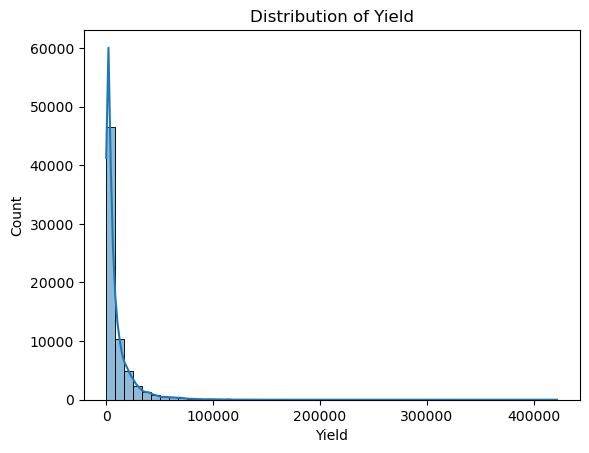

In [32]:
# Plotting Yield distribution
sns.histplot(merged_df['Yield'], bins=50, kde=True)
plt.title('Distribution of Yield')
plt.show()

Above graph shows extremly right scewed distribution, therefore I checked for possible outliers

In [33]:
#Identify values above 99.97% percentile, I reached this percentile number after testing running my MLP model later without removing this high Yields
threshold = merged_df['Yield'].quantile(0.9997)
high_yields = merged_df[merged_df['Yield'] > threshold]
high_yields_sorted = high_yields.sort_values(by='Yield', ascending=False)

In [34]:
high_yields_sorted.head()

,country,year,Item,Yield,Land_cover_percent_mean,CanopInt_mean,Rainf_mean,ESoil_mean,Snowf_mean,TWS_mean,SoilMoi,SoilTMP
22416,Dominican Republic,2019,Watermelons,421797.6,0.0,0.066851,0.000028,32.295969,0.0,845.125820,109.755163,298.489374
22476,Dominican Republic,2021,Watermelons,387816.7,0.0,0.061658,0.000026,35.825788,0.0,857.499264,114.834216,298.074954
22446,Dominican Republic,2020,Watermelons,386306.4,0.0,0.062073,0.000031,33.218645,0.0,862.688200,115.750680,298.564919
22386,Dominican Republic,2018,Watermelons,369380.0,0.0,0.066232,0.000031,37.222429,0.0,893.073744,130.062331,298.072210
22506,Dominican Republic,2022,Watermelons,311814.3,0.0,0.068539,0.000036,35.694323,0.0,870.816678,120.166415,297.847384


As it can be ssen in above sample view a small number of crop-country pairs exhibited unrealistically high yield values (e.g., Watermelons in the Dominican Republic, Papayas in Guyana, etc.), with yields exceeding 200,000–300,000 kg/ha. 
Note: Although extreme yields were retained for realism, but should be reviewed by domain experts if model is going to be implemented in operational level

In [35]:
print('number of data points to be removed because unrelistically high yield values is:', len(high_yields_sorted))

number of data points to be removed because unrelistically high yield values is: 21


In [36]:
# Yield above 99.99 percentile removed. 
merged_df = merged_df[merged_df['Yield'] <= threshold]

**Log Transformation of Target Variable (Yield)**

As it can seen in the plot above, the target variable 'Yield' shows a skewed distribution. In regression tasks, such imbalance where some ranges of the target (e.g., high crop yields) are underrepresented can bias the model toward predicting the more common values. Unlike classification, where class weights or oversampling are often applied, regression requires other techniques to address this imbalance.

One effective approach is to apply a __logarithmic transformation__ to the target variable. This reduces skewness, and making the model more robust to extreme values. In this report, we use the log transformation defined as:

`y_transformed = np.log1p(y)`  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*(log(1 + y) safely handles zero values)*

After training, we reverse the transformation on predictions using:

`y_pred = np.expm1(y_transformed_pred)`  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*(exp(y) - 1 to recover original scale)*

This transformation helps the MLP model learn from a balanced representation of yield values and predict better.


In [37]:
### Transforming yield to reduce Skewness
merged_df['yield_log'] = np.log1p(merged_df['Yield'])   # log1p(y)= log(1 + y)

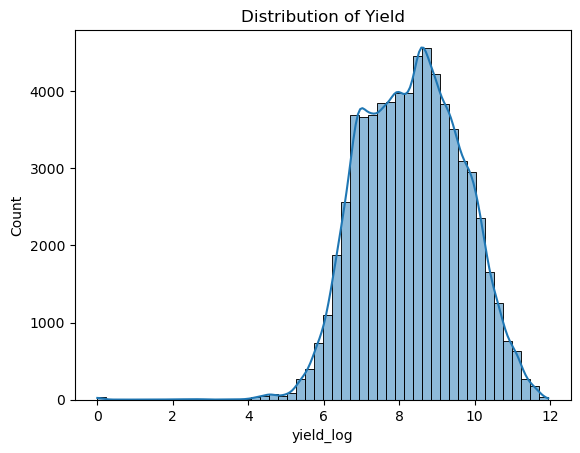

In [38]:
sns.histplot(merged_df['yield_log'], bins=50, kde=True)
plt.title('Distribution of Yield')
plt.show()

### 3-12: Final Cleaned DataFrame

In [39]:
merged_df.head()

,country,year,Item,Yield,Land_cover_percent_mean,CanopInt_mean,Rainf_mean,ESoil_mean,Snowf_mean,TWS_mean,SoilMoi,SoilTMP,yield_log
0,Afghanistan,2010,Apples,7000.0,0.0,0.004107,0.000007,19.008088,0.000001,705.892132,115.389781,288.76838,8.853808
1,Afghanistan,2010,Apricots,8000.0,0.0,0.004107,0.000007,19.008088,0.000001,705.892132,115.389781,288.76838,8.987322
2,Afghanistan,2010,Barley,2061.3,0.0,0.004107,0.000007,19.008088,0.000001,705.892132,115.389781,288.76838,7.631577
3,Afghanistan,2010,Cantaloupes and other melons,9870.3,0.0,0.004107,0.000007,19.008088,0.000001,705.892132,115.389781,288.76838,9.197387
4,Afghanistan,2010,Figs,4500.0,0.0,0.004107,0.000007,19.008088,0.000001,705.892132,115.389781,288.76838,8.412055


In [40]:
merged_df.shape

(67760, 13)

In [41]:
print('Number of unique Crop items in the final dataset:', len(merged_df['Item'].unique()))

Number of unique Crop items in the final dataset: 102


In [42]:
print('Number of unique contries in the final dataset:', len(merged_df['country'].unique()))

Number of unique contries in the final dataset: 163


# 4: Modeling 

## Data Setup and Categorical Feature Handling

Our final cleaned dataset has the following structure:

- **Input features**:
  - **Categorical**: `country`, `Item`
  - **Numerical**: `year`, `Land_cover_percent_mean`, `CanopInt_mean`, `Rainf_mean`, `ESoil_mean`, `Snowf_mean`, `TWS_mean`, `SoilMoi`, `SoilTMP`
- **Output**:
  - `yield_log` = log(1 + Yield)

We use log-transformation (`log1p`) on the target `Yield` to reduce skewness and stabilize variance. After prediction, we reverse it using `expm1`.

### Handling Categorical Variables

- ML models require numerical inputs, but `country` and `Item` are categorical (strings). We have many categories (e.g., countries, crops).
- **One solution**is to use embedding-based encoding for categorical variables. Categorical features like 'country' and 'Item' are first converted into integer indices using label encoding. {data[col + '_idx'] = data[col].cat.codes},  This assigns each unique category an integer ID. Inside the neural network, these integer indices are passed to nn.Embedding layers, which map each index to a learnable dense vector (e.g., 50-dim).

  {self.embeddings = nn.ModuleList([  
    nn.Embedding(num_categories, emb_dim)  
    for num_categories, emb_dim in emb_dims])}



### 4-1:  Split into training, validation, and test sets

Since our data is temporal (by year), we can split by year to simulate forecasting. The split I used:

- Train: majority of historical years (e.g. 2010–2019)

- Validation: cabe one or two recent years (I used year a random year, in my case random see 10 shows year 2019)

- Test: the final year (2022)

In [43]:
# --------------------- Data Setup for MLP with Embedding Layers in PyTorch--------------------------------
data = deepcopy(merged_df)

np.random.seed(10)  # For reproducibility
years = list(range(2010, 2022))
val_year = np.random.choice(years, size=1)[0]
test_year = 2022
print(f"Test Year: {test_year}, Validation Year: {val_year}")


# defining splits
categorical_cols = ['country', 'Item']
# year only used for spliting, not a numeric feature
numeric_cols = ['Land_cover_percent_mean', 'CanopInt_mean','Rainf_mean','ESoil_mean', 'Snowf_mean', 'TWS_mean',
                'SoilMoi', 'SoilTMP']
target_col = 'yield_log'

#preparing category Encoding (label Encoding)
# encoding categorical features as integer indices
for col in categorical_cols:
    data[col] = data[col].astype('category')
    data[col + '_idx'] = data[col].cat.codes

train_df = data[~data['year'].isin([test_year] + [val_year])].copy()
val_df = data[data['year']==val_year].copy()
test_df = data[data['year'] == test_year].copy()

print ('data instances used for traning:',len(train_df))
print ('data instances used for validation:',len(val_df))
print ('data instances used for test:',len(test_df))


# Scaling numeric features
scaler = StandardScaler()
train_num = scaler.fit_transform(train_df[numeric_cols])
val_num = scaler.transform(val_df[numeric_cols])
test_num = scaler.transform(test_df[numeric_cols])

# get categorical indices
train_cat = train_df[[col + '_idx' for col in categorical_cols]].values
val_cat = val_df[[col + '_idx' for col in categorical_cols]].values
test_cat = test_df[[col + '_idx' for col in categorical_cols]].values

# targets (target_col = 'yield_log') 
Y_train = train_df[target_col].values.astype(np.float32)
Y_val = val_df[target_col].values.astype(np.float32)
Y_test = test_df[target_col].values.astype(np.float32)

Test Year: 2022, Validation Year: 2019
data instances used for traning: 57445
data instances used for validation: 5141
data instances used for test: 5174


### 4-2 Model Architecture

In [44]:
import numpy
# --------------------------------- Model ----------------------------------------------------------------
### Create the methods to be used

# Create the neural network structure
# for a 3-layer MLP, with output size of one

class YieldMLP(nn.Module):
    def __init__(self,
                 input_size,
                 emb_dims,
                 hidden_layer_sizes,
                 output_size=1):
        super().__init__()

        # Embedding layers for categorical features
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories, emb_dim)
            for num_categories, emb_dim in emb_dims
        ])
        
        emb_input_dim = sum(e[1] for e in emb_dims)  # total embedding size
        
        # Fully connected layers
        self.hidden_l1 = nn.Linear(input_size + emb_input_dim, hidden_layer_sizes[0])
        self.hidden_l2 = nn.Linear(hidden_layer_sizes[0], hidden_layer_sizes[1])
        self.output_l3 = nn.Linear(hidden_layer_sizes[1], output_size)
        
        # LeakyReLU activation (alpha = 0.01 by default)
        self.activation = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x_num, x_cat):
        # Apply embedding to each categorical feature
        embedded = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        # Concatenate embeddings and numerical features
        out = torch.cat(embedded + [x_num], dim=1)
        # Forward pass through hidden layers with LeakyReLU
        out = self.activation(self.hidden_l1(out))
        out = self.activation(self.hidden_l2(out))
        # Final output layer
        return self.output_l3(out).squeeze(1)

# ---------------------------- Dataset Class ---------------------------------------------------------- 
class YieldDataset(Dataset):
    def __init__(self, num_feats, cat_feats, targets):
        self.num_feats = torch.tensor(num_feats, dtype=torch.float32)
        self.cat_feats = torch.tensor(cat_feats, dtype=torch.long)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.num_feats[idx, :], self.cat_feats[idx], self.targets[idx]

        
# I decided not to create a method for computing performance, because calculating it in the MLP loop was easier to read and understand the
# code, althought less efficient

### 4-3: Training and using our best trained model to predict results for year 2022

Found improvement in performance. New model saved.
Epoch: 0 | Train Loss: 1.1693 | Val Loss: 1.3774 | Train MAE: 5975.2461 | Val MAE: 7083.3037
Found improvement in performance. New model saved.
Epoch: 1 | Train Loss: 0.8621 | Val Loss: 0.8515 | Train MAE: 5275.9712 | Val MAE: 5667.3472
Found improvement in performance. New model saved.
Epoch: 2 | Train Loss: 0.4891 | Val Loss: 0.6549 | Train MAE: 4605.9067 | Val MAE: 4940.4395
Found improvement in performance. New model saved.
Epoch: 3 | Train Loss: 0.5016 | Val Loss: 0.5571 | Train MAE: 4108.9590 | Val MAE: 4509.2642
Found improvement in performance. New model saved.
Epoch: 4 | Train Loss: 0.5448 | Val Loss: 0.4972 | Train MAE: 4372.8677 | Val MAE: 4227.7222
Found improvement in performance. New model saved.
Epoch: 5 | Train Loss: 0.4724 | Val Loss: 0.4587 | Train MAE: 3620.4797 | Val MAE: 4050.6260
Found improvement in performance. New model saved.
Epoch: 6 | Train Loss: 0.4064 | Val Loss: 0.4293 | Train MAE: 4148.8105 | Val MAE: 39

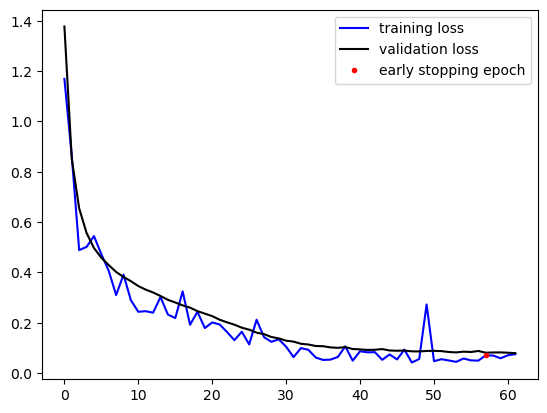

In [46]:

### Train and evaluate the 3-layer MLP for regression

# Ensure reproducibility
# for PyTorch operations that use random numbers internally
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)


# Set values for hyperparameters, # learning_rate, batch_size, weight_decay and hidden_layer_sizes adjusted based on our grid search for 
# the best hyperparameters (see the final part of this notebook)

learning_rate =0.0001
hidden_layer_sizes = [512, 512]
batch_size = 400
weight_decay = 1e-4
num_epochs = 200

# first lets define embedding dimensions: (num_categories, embedding_dim), and num_input_dim size
emb_dims = [ (data['country'].nunique(), min(50, (data['country'].nunique() + 1) // 2)),
            (data['Item'].nunique(), min(50, (data['Item'].nunique() + 1) // 2))] # from internet forums {embedding_dim = min(50, (num_categories + 1) // 2) =50} can be used
num_input_dim=train_num.shape[1]
# Create an instance of the 3-layer MLP
MLP_model = YieldMLP(num_input_dim, emb_dims=emb_dims, hidden_layer_sizes= hidden_layer_sizes, output_size=1)



# Set up the data loading by batch
# With the test and validation sets having only one batch
train_ds = YieldDataset(train_num, train_cat, Y_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

val_ds = YieldDataset(val_num, val_cat, Y_val)
val_loader = DataLoader(val_ds, batch_size=len(val_ds))

test_ds = YieldDataset(test_num, test_cat, Y_test)
test_loader = DataLoader(test_ds, batch_size=len(test_ds))


# Set up the Adam optimizer for updating the model weights (I tried SGD with different parameters, I did not get good results)
optimizer = optim.Adam(MLP_model.parameters(), lr=learning_rate, weight_decay = weight_decay) # #The weight_decay parameter in the optimizer (e.g., optim.Adam(...)) is used to apply L2 regularization, 
                                                                                #which helps prevent overfitting in our model.

# Compute MSE loss against the training targets/lables
loss_function = nn.MSELoss()


# ----------------------------------  Loop ------------------------------------ 
best_val_MAE = np.inf
patience = 5
epochs_no_improve = 0
losses = []
# Iterate over the dataset at two different stages:
# 1. Iterate over the batches in the dataset (inner for loop below)
# One complete set of iteration through the dataset (i.e. having gone over
# all batches in the dataset at least once) = One epoch
# 2. Iterate over the specified numeber of epochs (outer for loop below)

for epoch in range(num_epochs):
    # Set the model to training mode
    MLP_model.train()
    # Initialize for early stopping
    
    if epoch == 0:
      best_model = deepcopy(MLP_model)
      best_epoch = 0
        
    for batch_idx, (x_train_num, x_train_cat, y_train) in enumerate(train_loader):      
        # Zero out the `.grad` buffers, otherwise on the backward pass we'll add the new gradients to the old ones.
        optimizer.zero_grad()
        # Compute the forward pass and then the loss
        train_pred = MLP_model.forward(x_train_num, x_train_cat)
        train_loss = loss_function(train_pred, y_train)
        #I used MAE as my main performance metric because it is less sensetive to outliers. And I showed in yield distribution earlier yield is
        # heavily right skewed
        train_MAE = mean_absolute_error(np.expm1(y_train), np.expm1(train_pred.detach().numpy()))
        
        # Compute the model parameters' gradients
        # and propagating the loss backwards through the network.
        train_loss.backward()
        
        # Update the model parameters using those gradients
        optimizer.step()
    
# ------------------------- Evaluation on validation set and early stpping--------------------- ----------------
    # Evaluate on the validation set for early stopping based on root mean square error (RMSE)
    # Validation    
    MLP_model.eval()  # Set the model to evaluation mode
    
    for batch, (x_val_num, x_val_cat, y_val) in enumerate(val_loader):  # Iterate over the validation DataLoader
        # we do not need to compute gradients, in eval mode we are not updating the model weights --> .forward()              
        val_pred = MLP_model.forward(x_val_num, x_val_cat)
        val_loss = loss_function (val_pred, y_val)
        #I used MAE as my main performance metric because it is less sensetive to outliers. And I showed in yield distribution earlier yield is
        # heavily right skewed
        val_MAE = mean_absolute_error(np.expm1(y_val), np.expm1(val_pred.detach().numpy()))  #expm1 :converting values back to original format from log format


    if val_MAE < best_val_MAE:   # we can also use val_MSE (i.e, val_RMSE**2) for early stopping, the results of both has no differrence
        best_epoch = epoch
        best_val_MAE = val_MAE
        best_model = deepcopy(MLP_model)
        epochs_no_improve = 0
        print('Found improvement in performance. New model saved.')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
            
    # How well the network does on the batches
    # is an indication of how well training is progressing
    print("Epoch: {} | Train Loss: {:.4f} | Val Loss: {:.4f} | Train MAE: {:.4f} | Val MAE: {:.4f}".format(
        epoch,
        train_loss.item(),
        val_loss.item(),
        train_MAE,
        val_MAE))
    
    losses.append([train_loss.item(), val_loss.item()])

MLP_model_best = best_model
# ------------------------- Evaluation on test set--------------------- ----------------
# Finally, test our model on the test set (2022 data) and get an estimate of its performance.
# First, set the "best model" ,trained in above loop, to evaluation mode

MLP_model_best.eval()

for batch, (x_test_num, x_test_cat, y_test) in enumerate(test_loader):  # Iterate over the test DataLoader
           
    test_pred = MLP_model_best.forward(x_test_num, x_test_cat)
    test_MAE = mean_absolute_error(np.expm1(y_test), np.expm1(test_pred.detach().numpy()))
    test_RMSE = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(test_pred.detach().numpy())))
    test_r2 = r2_score(np.expm1(y_test), np.expm1(test_pred.detach().numpy()))
    test_MSE = mean_squared_error(np.expm1(y_test), np.expm1(test_pred.detach().numpy()))
    #e.g., test_pred_numpy = test_pred.detach().numpy() #---> converts back from torch format
    
    print("\n test MAE: {:2.2f}".format(test_MAE))
    print("\n test RMSE: {:2.2f}".format(test_RMSE))
    print("\n test R2: {:2.2f}".format(test_r2))
    print("\n test MSE: {:2.2f}".format(test_MSE))
   
    print("\n Loss graph:")
    fig, ax = plt.subplots()
    losses = numpy.array(losses)
    ax.plot(losses[:, 0], 'b-', label='training loss')
    ax.plot(losses[:, 1], 'k-', label='validation loss')
    ax.plot(best_epoch, losses[best_epoch, 0], 'r.', label='early stopping epoch')
    plt.legend(loc='upper right')


#### 4-4: Saving predictions and actual yields per country and Item for the year 2022

In [47]:
# first converting predictions for the year 2022 back to original scale
predicted_yield = np.expm1(test_pred.detach().numpy()).flatten()
actual_yield = np.expm1(y_test.detach().numpy()).flatten()

# reset index of test_df to align row-by-row
df_test_results = test_df.reset_index(drop=True)

# creating DataFrame and saving CSV file
output_df = pd.DataFrame({
    'country': df_test_results['country'],
    'crop': df_test_results['Item'],
    'actual_yield': actual_yield.astype(int),
    'predicted_yield': predicted_yield.astype(int) })


output_df.to_csv("MLP_yield_predictions_test_2022.csv", index=False, float_format='%.2f')


In [48]:
# A quick peek at our model output that shows predicted vs. actual yields for the year 2022
output_df.sample(10)

,country,crop,actual_yield,predicted_yield
1566,El Salvador,"Treenuts, Total",783,706
1988,Guinea-Bissau,"Groundnuts, excluding shelled",1188,1152
1235,Cuba,Maize (corn),1756,2253
4412,Syrian Arab Republic,Grapes,5222,5152
5002,Uzbekistan,Watermelons,34334,35837
1471,Ecuador,Quinoa,1056,1035
1129,Colombia,"Peas, dry",1543,2024
3754,Qatar,Cereals n.e.c.,6150,5945
4821,United Republic of Tanzania,Castor oil seeds,428,551
530,Bhutan,Mustard seed,639,821


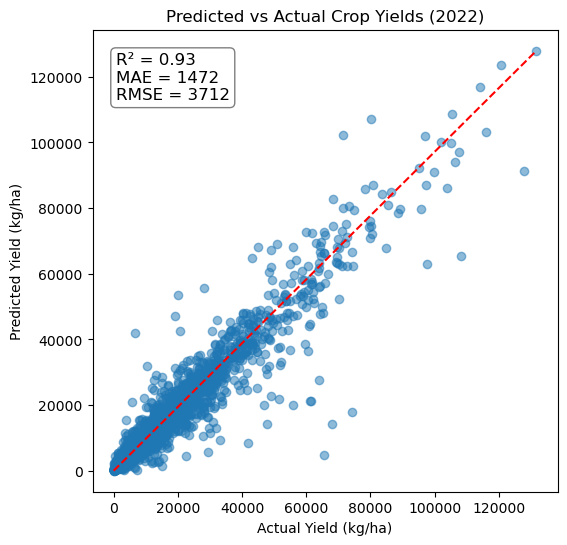

In [49]:
r2 = r2_score(actual_yield, predicted_yield)
rmse = np.sqrt(mean_squared_error(actual_yield, predicted_yield))
MAE = mean_absolute_error(actual_yield, predicted_yield)


plt.figure(figsize=(6, 6))
plt.scatter(output_df['actual_yield'], output_df['predicted_yield'], alpha=0.5)
plt.plot([0, max(output_df['actual_yield'])], [0, max(output_df['predicted_yield'])], 'r--')
plt.xlabel('Actual Yield (kg/ha)')
plt.ylabel('Predicted Yield (kg/ha)')
plt.title('Predicted vs Actual Crop Yields (2022)')
plt.text(0.05, 0.95,
         f"R² = {r2:.2f}\nMAE = {MAE:.0f} \nRMSE = {rmse:.0f}",
         transform=plt.gca().transAxes,
         fontsize=12,
         verticalalignment='top',
         bbox=dict(boxstyle="round", facecolor='white', alpha=0.5))
plt.show()

### 4-5:  Grid Search: finding best  lr, batch_size, hidden_sizes and weight_decay using grid search

for unbiased performance evaluation during grid search we use two randomly chosen years between 2010 to 2021, to be used fo filtering data for test and validation sets. 
Year 2022 held out entirely.

In [45]:
# I intentionally changed the variable names to uppercase, so when running between codes the variables with similar names not mixed
from itertools import product

DATA = deepcopy(merged_df)
np.random.seed(45)  # For reproducibility
YEARS = list(range(2010, 2022))
VAL_YEAR, TEST_YEAR = np.random.choice(YEARS, size=2, replace=False)

print(f"Test Year: {TEST_YEAR}, Validation Year: {VAL_YEAR}")

# defining splits
CATEGORICAL_COLS = ['country', 'Item']
NUMERIC_COLS = ['Land_cover_percent_mean', 'CanopInt_mean', 'Rainf_mean', 'ESoil_mean', 'Snowf_mean', 'TWS_mean',
                'SoilMoi', 'SoilTMP']
TARGET_COL = 'yield_log'

# encoding categorical features
for COL in CATEGORICAL_COLS:
    DATA[COL] = DATA[COL].astype('category')
    DATA[COL + '_idx'] = DATA[COL].cat.codes

TRAIN_DF = DATA[~DATA['year'].isin([TEST_YEAR] + [VAL_YEAR])].copy()
VAL_DF = DATA[DATA['year'] == VAL_YEAR].copy()
TEST_DF = DATA[DATA['year'] == TEST_YEAR].copy()

# Scaling numeric features
SCALER = StandardScaler()
TRAIN_NUM = SCALER.fit_transform(TRAIN_DF[NUMERIC_COLS])
VAL_NUM = SCALER.transform(VAL_DF[NUMERIC_COLS])
TEST_NUM = SCALER.transform(TEST_DF[NUMERIC_COLS])

# get categorical indices
TRAIN_CAT = TRAIN_DF[[COL + '_idx' for COL in CATEGORICAL_COLS]].values
VAL_CAT = VAL_DF[[COL + '_idx' for COL in CATEGORICAL_COLS]].values
TEST_CAT = TEST_DF[[COL + '_idx' for COL in CATEGORICAL_COLS]].values

# targets
Y_TRAIN = TRAIN_DF[TARGET_COL].values.astype(np.float32)
Y_VAL = VAL_DF[TARGET_COL].values.astype(np.float32)
Y_TEST = TEST_DF[TARGET_COL].values.astype(np.float32)


# ------------------ Grid Search ------------------

def run_grid_search(TRAIN_NUM, TRAIN_CAT, Y_TRAIN,
                    VAL_NUM, VAL_CAT, Y_VAL,
                    TEST_NUM, TEST_CAT, Y_TEST,
                    PARAM_GRID,
                    NUM_EPOCHS=200, PATIENCE=5):

    RESULTS = []
    EMB_DIMS = [(DATA['country'].nunique(), min(50, (DATA['country'].nunique() + 1) // 2)),
                (DATA['Item'].nunique(), min(50, (DATA['Item'].nunique() + 1) // 2))]


    for LR, BATCH_SIZE, HIDDEN_SIZES, WEIGHT_DECAY in product(
        PARAM_GRID['lr'], PARAM_GRID['batch_size'],
        PARAM_GRID['hidden_sizes'], PARAM_GRID['weight_decay']):

        print(f"\n Results for: lr={LR}, batch_size={BATCH_SIZE}, hidden_sizes={HIDDEN_SIZES}, weight_decay={WEIGHT_DECAY}")
        
        MLP_MODEL = YieldMLP(input_size=TRAIN_NUM.shape[1], emb_dims=EMB_DIMS,
                             hidden_layer_sizes=HIDDEN_SIZES, output_size=1)

        TRAIN_DS = YieldDataset(TRAIN_NUM, TRAIN_CAT, Y_TRAIN)
        VAL_DS = YieldDataset(VAL_NUM, VAL_CAT, Y_VAL)
        TEST_DS = YieldDataset(TEST_NUM, TEST_CAT, Y_TEST)

        TRAIN_LOADER = DataLoader(TRAIN_DS, batch_size=BATCH_SIZE, shuffle=True)
        VAL_LOADER = DataLoader(VAL_DS, batch_size=len(VAL_DS))
        TEST_LOADER = DataLoader(TEST_DS, batch_size=len(TEST_DS))

        OPTIMIZER = optim.Adam(MLP_MODEL.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
        LOSS_FUNCTION = nn.MSELoss()

        BEST_VAL_MAE = np.inf
        EPOCHS_NO_IMPROVE = 0
        LOSSES = []

        for EPOCH in range(NUM_EPOCHS):
            MLP_MODEL.train()

            if EPOCH == 0:
                BEST_MODEL = deepcopy(MLP_MODEL)
                BEST_EPOCH = 0

            for BATCH_IDX, (X_TRAIN_NUM, X_TRAIN_CAT, Y_TRAIN_BATCH) in enumerate(TRAIN_LOADER):
                OPTIMIZER.zero_grad()
                TRAIN_PRED = MLP_MODEL.forward(X_TRAIN_NUM, X_TRAIN_CAT)
                TRAIN_LOSS = LOSS_FUNCTION(TRAIN_PRED, Y_TRAIN_BATCH)
                TRAIN_MAE = mean_absolute_error(np.expm1(Y_TRAIN_BATCH), np.expm1(TRAIN_PRED.detach().numpy()))
                TRAIN_LOSS.backward()
                OPTIMIZER.step()

            MLP_MODEL.eval()
            for BATCH, (X_VAL_NUM, X_VAL_CAT, Y_VAL_BATCH) in enumerate(VAL_LOADER):
                VAL_PRED = MLP_MODEL.forward(X_VAL_NUM, X_VAL_CAT)
                VAL_LOSS = LOSS_FUNCTION(VAL_PRED, Y_VAL_BATCH)
                VAL_MAE = mean_absolute_error(np.expm1(Y_VAL_BATCH), np.expm1(VAL_PRED.detach().numpy()))

            if VAL_MAE < BEST_VAL_MAE:
                BEST_EPOCH = EPOCH
                BEST_VAL_MAE = VAL_MAE
                BEST_MODEL = deepcopy(MLP_MODEL)
                EPOCHS_NO_IMPROVE = 0
            else:
                EPOCHS_NO_IMPROVE += 1
                if EPOCHS_NO_IMPROVE >= PATIENCE:
                    break

            LOSSES.append([TRAIN_LOSS.item(), VAL_LOSS.item()])

        MLP_MODEL_BEST = BEST_MODEL
        MLP_MODEL_BEST.eval()

        for BATCH, (X_TEST_NUM, X_TEST_CAT, Y_TEST_BATCH) in enumerate(TEST_LOADER):
            TEST_PRED = MLP_MODEL_BEST.forward(X_TEST_NUM, X_TEST_CAT)
            TEST_RMSE = np.sqrt(mean_squared_error(np.expm1(Y_TEST_BATCH), np.expm1(TEST_PRED.detach().numpy())))
            TEST_R2 = r2_score(np.expm1(Y_TEST_BATCH), np.expm1(TEST_PRED.detach().numpy()))
            TEST_MAE = mean_absolute_error(np.expm1(Y_TEST_BATCH), np.expm1(TEST_PRED.detach().numpy()))

            print(" test RMSE: {:2.2f}".format(TEST_RMSE))
            print(" test R2: {:2.2f}".format(TEST_R2))
            print(" test MAE: {:2.2f}".format(TEST_MAE))

        RESULTS.append({
            'lr': LR,
            'batch_size': BATCH_SIZE,
            'hidden_sizes': HIDDEN_SIZES,
            'weight_decay': WEIGHT_DECAY,
            'R2': TEST_R2,
            'MAE': TEST_MAE,
            'RMSE': TEST_RMSE})

    RESULTS1 = sorted(RESULTS, key=lambda x: x['RMSE'])
    RESULTS2 = sorted(RESULTS, key=lambda x: x['MAE'])
    RESULTS3 = sorted(RESULTS, key=lambda x: x['R2'], reverse=True)

    print("\nBest Configuration for low RMSE:", RESULTS1[0])
    print("Best Configuration for low MAE:", RESULTS2[0])
    print("Best Configuration for high R2:", RESULTS3[0])

    return {
        'best_mse': RESULTS1[0],
        'best_mae': RESULTS2[0],
        'best_r2': RESULTS3[0],
        'all_results': RESULTS}


# Run grid search
PARAM_GRID = {
    'lr': [1e-4, 1e-3, 1e-2],
    'batch_size': [100, 200, 400],
    'hidden_sizes': [(256, 256), (512, 256), (512,512)],
    'weight_decay': [1e-5, 1e-4, 1e-3]}

RESULTS_DICT = run_grid_search(
    TRAIN_NUM, TRAIN_CAT, Y_TRAIN,
    VAL_NUM, VAL_CAT, Y_VAL,
    TEST_NUM, TEST_CAT, Y_TEST,
    PARAM_GRID)

BEST_CONFIG_MSE = RESULTS_DICT['best_mse']
BEST_CONFIG_MAE = RESULTS_DICT['best_mae']
BEST_CONFIG_R2 = RESULTS_DICT['best_r2']


Test Year: 2016, Validation Year: 2012

 Results for: lr=0.0001, batch_size=100, hidden_sizes=(256, 256), weight_decay=1e-05
 test RMSE: 2949.65
 test R2: 0.95
 test MAE: 1157.81

 Results for: lr=0.0001, batch_size=100, hidden_sizes=(256, 256), weight_decay=0.0001
 test RMSE: 2965.99
 test R2: 0.95
 test MAE: 1214.03

 Results for: lr=0.0001, batch_size=100, hidden_sizes=(256, 256), weight_decay=0.001
 test RMSE: 3368.57
 test R2: 0.94
 test MAE: 1381.21

 Results for: lr=0.0001, batch_size=100, hidden_sizes=(512, 256), weight_decay=1e-05
 test RMSE: 3312.31
 test R2: 0.94
 test MAE: 1385.47

 Results for: lr=0.0001, batch_size=100, hidden_sizes=(512, 256), weight_decay=0.0001
 test RMSE: 3099.18
 test R2: 0.95
 test MAE: 1270.64

 Results for: lr=0.0001, batch_size=100, hidden_sizes=(512, 256), weight_decay=0.001
 test RMSE: 3248.50
 test R2: 0.94
 test MAE: 1361.13

 Results for: lr=0.0001, batch_size=100, hidden_sizes=(512, 512), weight_decay=1e-05
 test RMSE: 3120.45
 test R2: 0.9

__Best configuration for hyperparameters__

Best Configuration for low MAE: {'lr': 0.0001, 'batch_size': 400, 'hidden_sizes': (512, 512), 'weight_decay': 0.0001, '}